### Data Import

Import the data from the data directory containing METRo forecasts and monitor data from 29th of October 2018 till the 14th of March 2019.

In [ ]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

df = loader()

### Define the feature space

Here the features are defined that are used for the METRo forecasts

In [ ]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

### Hyperparameter Extraction

Here the functions are defined for extracting the hyperparameters of the neural networks using a randomized search.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def create_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=17))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model
    
def get_best_parameters(samples, targets):
    model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=50, verbose=0) 

    # Define the range
    neurons = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
    batch_size = [20, 40, 50, 60, 80, 100]
    epochs = [10, 20, 40, 50]
    param_grid = dict(neurons=neurons, batch_size=batch_size, epochs=epochs)
    
    dnn_random = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 3, verbose=2, n_iter = 100)
    dnn_random.fit(samples, targets)
    
    return dnn_random.best_params_

### Retrieving the hyperparameters
Here the best hyperparameters are extracted for each model. This takes a while to test, but the from running this experiment yielded:

```
neuron_params = dict()

neuron_params[(1419, 1)] = {'neurons': 74, 'epochs': 100, 'batch_size': 10}
neuron_params[(1419, 5)] = {'neurons': 235, 'epochs': 100, 'batch_size': 20}
neuron_params[(1419, 9)] = {'neurons': 267, 'epochs': 40, 'batch_size': 20}
neuron_params[(1419, 18)] = {'neurons': 138, 'epochs': 40, 'batch_size': 10}
neuron_params[(1433, 1)] = {'neurons': 138, 'epochs': 100, 'batch_size': 10}
neuron_params[(1433, 5)] = {'neurons': 267, 'epochs': 50, 'batch_size': 40}
neuron_params[(1433, 9)] = {'neurons': 267, 'epochs': 40, 'batch_size': 40}
neuron_params[(1433, 18)] = {'neurons': 235, 'epochs': 50, 'batch_size': 40}
neuron_params[(1440, 1)] = {'neurons': 300, 'epochs': 40, 'batch_size': 20}
neuron_params[(1440, 5)] = {'neurons': 203, 'epochs': 40, 'batch_size': 20}
neuron_params[(1440, 9)] = {'neurons': 267, 'epochs': 50, 'batch_size': 20}
neuron_params[(1440, 18)] = {'neurons': 300, 'epochs': 50, 'batch_size': 20}
neuron_params[(1417, 1)] = {'neurons': 267, 'epochs': 40, 'batch_size': 50}
neuron_params[(1417, 5)] = {'neurons': 235, 'epochs': 50, 'batch_size': 20}
neuron_params[(1417, 9)] = {'neurons': 300, 'epochs': 40, 'batch_size': 20}
neuron_params[(1417, 18)] = {'neurons': 171, 'epochs': 50, 'batch_size': 20}
```

In [ ]:
dfTest = loader()
neuron_params = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key])
        
        best_params = get_best_parameters(X_train, y_train)
        neuron_params[key] = best_params
        print(key, best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=235, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=235, epochs=50, batch_size=20, total=   6.4s
[CV] neurons=235, epochs=50, batch_size=20 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ............ neurons=235, epochs=50, batch_size=20, total=   7.3s
[CV] neurons=235, epochs=50, batch_size=20 ...........................
[CV] ............ neurons=235, epochs=50, batch_size=20, total=   5.9s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   3.7s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   3.3s
[CV] neurons=10, epochs=50, batch_size=40 ............................
[CV] ............. neurons=10, epochs=50, batch_size=40, total=   2.6s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=   1.7s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] ............ neurons=203, epochs=20, batch_size=50, total=   1.6s
[CV] neurons=203, epochs=20, batch_size=50 ...........................
[CV] .

[CV] ........... neurons=106, epochs=40, batch_size=100, total=   5.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.3min finished


(1417, 5) {'neurons': 235, 'epochs': 50, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=235, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ neurons=235, epochs=40, batch_size=60, total=   6.3s
[CV] neurons=235, epochs=40, batch_size=60 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ............ neurons=235, epochs=40, batch_size=60, total=   6.1s
[CV] neurons=235, epochs=40, batch_size=60 ...........................
[CV] ............ neurons=235, epochs=40, batch_size=60, total=   8.4s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  11.2s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  10.7s
[CV] neurons=300, epochs=50, batch_size=40 ...........................
[CV] ............ neurons=300, epochs=50, batch_size=40, total=  13.4s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=50, batch_size=60, total=   5.9s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] ............ neurons=138, epochs=50, batch_size=60, total=   6.1s
[CV] neurons=138, epochs=50, batch_size=60 ...........................
[CV] .

[CV] ............ neurons=267, epochs=50, batch_size=50, total=  14.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  8.4min finished


(1417, 9) {'neurons': 300, 'epochs': 40, 'batch_size': 20}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] neurons=10, epochs=50, batch_size=50 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............. neurons=10, epochs=50, batch_size=50, total=   9.0s
[CV] neurons=10, epochs=50, batch_size=50 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ............. neurons=10, epochs=50, batch_size=50, total=  12.1s
[CV] neurons=10, epochs=50, batch_size=50 ............................
[CV] ............. neurons=10, epochs=50, batch_size=50, total=   7.9s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   5.8s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   8.3s
[CV] neurons=171, epochs=20, batch_size=80 ...........................
[CV] ............ neurons=171, epochs=20, batch_size=80, total=   7.3s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=40, batch_size=50, total=  11.9s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] ............ neurons=267, epochs=40, batch_size=50, total=  11.8s
[CV] neurons=267, epochs=40, batch_size=50 ...........................
[CV] .

[CV] ............ neurons=300, epochs=40, batch_size=60, total=  11.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.3min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1417, 18) {'neurons': 171, 'epochs': 50, 'batch_size': 20}


### Model Functions

These functions are used for normalizing the dataset as well as building and fitting the models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing
import sys
import pickle

def fit_nn(samples, targets, neurons=238, epochs=20, batch_size=50):
    model = Sequential()
    model.add(Dense(neurons, activation='relu',
             input_shape=(samples.shape[1],)))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    model.fit(samples, targets,
             epochs=epochs, batch_size=batch_size, verbose=0)
    
    # This prints the model size
    p = pickle.dumps(model)
    print(sys.getsizeof(p))
    
    return model

def forecast_nn(model, samples):
    predictions = model.predict(samples)
    return predictions

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    train /= std

    test -= mean
    test /= std
    return train, test

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


Using TensorFlow backend.


### Plot predictions

Used for plotting a graph depicting the true and estimated target value for approximations about model accuracy and overfitting/underfitting analysis.

In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=10)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

### Experiment 1

The first experiment tested on the dataset collected from the winter season

In [ ]:
def experiment(repeats, data, key):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)
    
    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    print(X_train.shape)
    for r in range(repeats):
        forest_model = fit_nn(X_train, y_train)

        predictions = forecast_nn(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores

### Running the experiment

The experiment is run for the selected forecast lengths (1, 5, 9 and 18) which is extracted from the dataset.

In [ ]:
%matplotlib inline

repeats = 10
features = 1
results = dict()

trueVals = []
predictedVals = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment(repeats, df[key], key, neuron_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

### Saving and loading the results

The results from the first experiment is saved to the results directory. Another method is defined to retrieve the stored results.

In [ ]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/dnn/results_{}.csv".format(str(key)))

    with open("results/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

In [ ]:
def result_loader(directory='results'):
    """Reading data from keys"""
    with open("{}/dnn/keys.txt".format(directory), "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("{}/dnn/results_{}.csv".format(directory, str(key)))

    return dictex


### Depicting the Error Span of the Predictions

To better showcase the model estimations, an errorbar plot are created to depict the error span of the predictions contra the true value.

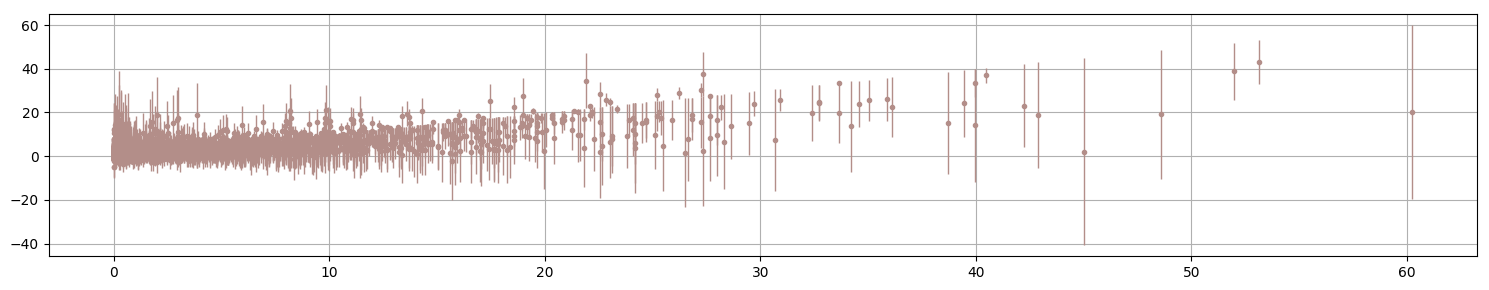

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
#plt.rcdefaults()

diffValsSquared = []
for i in range(len(trueVals_old)):
    diffValsSquared.append((trueVals_old[i] - predictedVals_old[i]) ** 2)
    
diffVals = [math.sqrt(number) for number in diffValsSquared]

# First illustrate basic pyplot interface, using defaults where possible.
plt.errorbar(trueVals_old, predictedVals_old, yerr=diffVals, fmt='.', elinewidth=1, color='#B38E89')
plt.grid(True)
plt.tight_layout()
plt.rcParams["figure.figsize"] = (15,3)

plt.savefig('error_selection_dnn.png')
plt.show()

### MSE result depiction

The following graphs depicts a boxplot for the results of the dense neural network models

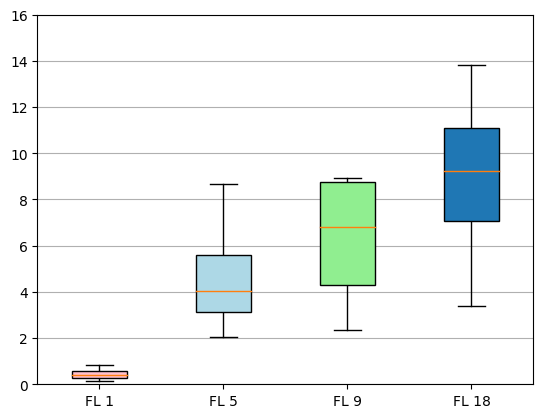

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
plt.rcdefaults()

results = result_loader()

all_data = dict()
# Random test data
for key in [1417, 1419, 1433, 1440]:
    for fl in [1, 5, 9, 18]:
        if fl not in all_data.keys():
            all_data[fl] = []
        all_data[fl].append(results[(key, fl)].values[0][1])
    labels = ['FL 1', 'FL 5', 'FL 9', 'FL 18']

all_data = list(all_data.values())
fig, axes = plt.subplots()

# rectangular box plot
bplot1 = axes.boxplot(all_data, 0, '',
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels)  # will be used to label x-ticks

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_ylim([0, 16])

plt.savefig('mse_box_plot_dnn.png'.format(str(key)))
plt.show()

### Loading the second dataset

Import the data from the data directory containing METRo forecasts and monitor data from 14th of March 2018 till the 5th of May 2019.

In [1]:
import pandas as pd
import numpy as np

def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

df = loader2()

### Experiment 2

The second experiment involves training the models on newer data collected from the spring season, that is, the models are reused and continously trained.

Below is the methods used for processing the dataset, which needed a different normalizing setting because some standard deviation outcomes were zero, which makes the scaled value zero for that feature (https://stackoverflow.com/a/54623752/7296909). 

In [ ]:
from keras.models import model_from_json
import h5py
import threading
import pandas as pd
import warnings
warnings.filterwarnings("error")
from keras.models import load_model

def getValues(data, test_size=0.3):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)

def fit_nn_with_loaded_weights(samples, targets, model, epochs, batch_size):
    loaded_model = load_model(model)    
    loaded_model.fit(samples, targets,
        epochs=epochs, batch_size=batch_size, verbose=0)

    p = pickle.dumps(loaded_model)
    print(sys.getsizeof(p))
    
    return loaded_model

def normalize(train, test):
    mean = train.mean(axis=0)    
    train -= mean
    std = train.std(axis=0)
    for i in range(len(std)):
        if (std[i] == 0.0):
            std[i] = 1.0
    train /= std

    test -= mean
    test /= std
    return train, test

### Experiment Method

Implementation for the second experiment loading saved model architectures, weights and compilers and fitting and testing them with the new dataset.

In [ ]:
def experiment2(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    
    for r in range(repeats):
        model_file = 'models/dnn/whole_models/model_{}_{}.h5'.format(key, r)
        forest_model = fit_nn_with_loaded_weights(X_train, 
                              y_train,
                              model_file,
                              epochs=params['epochs'],
                              batch_size=params['batch_size'])
        predictions = forecast_nn(forest_model, X_test)
        true = y_test
                
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores

### Running the experiment

The experiment is run for the selected forecast lengths (1, 5, 9 and 18) which is extracted from the dataset.

In [ ]:
repeats = 10
features = 1
results = dict()

trueVals = []
predictedVals = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment2(repeats, df[key], key, neuron_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)

### Saving the results from the second experiment

The results from the second experiment is saved to the results2 directory.

In [ ]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/dnn/results_{}.csv".format(str(key)))

    with open("results2/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

### Testing the models on the new dataset without continous training

This section tests the saved models on the new dataset without incrementally training the models on the new dataset. This is made to be able to compare if continous training of the models improves their accuracy compared to non-continously trained models.

In [ ]:
from keras.models import load_model

def experiment3(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    X_train, X_test = normalize(X_train, X_test)

    MSE_benchmark = 100
    index_val = 20
    predictionsBest = list()
    trueBest = list()

    error_scores = list()
    results = pd.DataFrame()
    print(key)
    
    for r in range(repeats):
        forest_model = load_model('models/dnn/whole_models/model_{}_{}.h5'.format(key, r))
        
        predictions = forecast_nn(forest_model, X_test)
        true = y_test
                
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        plotPredictions(key, true, predictions)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
    print(index_val, )
    return trueBest, predictionsBest, error_scores

In [ ]:
%matplotlib inline

df = loader2()

repeats = 10
features = 1
results_old = dict()

trueVals_old = []
predictedVals_old = []

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment3(repeats, df[key], key, neuron_params[key])
        results_old[key] = error_scores
        trueVals_old.extend(true)
        predictedVals_old.extend(predictions)

### Saving the results from the third experiment method
The results from the third experiment is saved to the results3 directory.

In [ ]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results3/dnn/results_{}.csv".format(str(key)))

    with open("results3/dnn/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

### Plotting the differences

Below snippet creates a graph that depicts the difference in average MSE between the models trained on the new dataset and the models NOT trained on the new dataset that were tested on the new dataset.

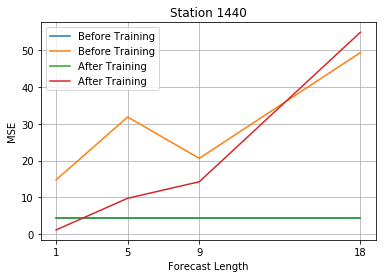

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

results = result_loader(directory='results2')
results_old = result_loader(directory='results3')

result_old_means = dict()
result_means = dict()

for key in results_old:
    result_old_means[key] = np.mean(results_old[key])
    result_means[key] = np.mean(results[key])

fig, ax = plt.subplots()

# Data for plotting
o = [result_old_means[(1440, 1)], result_old_means[(1440, 5)], result_old_means[(1440, 9)], result_old_means[(1440, 18)], ]
b = [1, 5, 9, 18]

ax.plot(b, o, label='Before Training')

# Data for plotting
t = [result_means[(1440, 1)], result_means[(1440, 5)], result_means[(1440, 9)], result_means[(1440, 18)], ]
s = [1, 5, 9, 18]

ax.plot(s, t, label='After Training')

ax.set(xlabel='Forecast Length', ylabel='MSE',
       title='Station 1440')
ax.grid()
ax.legend()
plt.xticks([1, 5, 9, 18])

# fig.savefig("mse_improvement_dnn_1440.png")
plt.show()